The purpose of this notebook is to explore the relative abundance distribution of vOTUs in the Grantham Bioreactor.

The data are metaT data, and we want to understand how the viral abundance is changing through time, as well as after treatment with catechin.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# import relative abundance data
# data was calculated by mapping all reads from metaT samples to vOTUs from Stordalen Mire vOTUs + metaG assemblies
#     coverage data was then calculated with coverM, and then normalized by dividing by the length of each contig
#     and the number of total reads in each sample

df = pd.read_csv('data/GeTMM_normalized_counts_readcounts.csv', sep=',')
df.rename(columns={'Unnamed: 0': 'Contig'}, inplace=True)
df.head()

,Contig,STM_0716_E_M_E002,STM_0716_E_M_E003,STM_0716_E_M_E004,STM_0716_E_M_E025,STM_0716_E_M_E027,STM_0716_E_M_E029,STM_0716_E_M_E030,STM_0716_E_M_E031,STM_0716_E_M_E033,...,STM_0716_E_M_E072,STM_0716_E_M_E121,STM_0716_E_M_E122,STM_0716_E_M_E123,STM_0716_E_M_E125,STM_0716_E_M_E126,STM_0716_E_M_E127,STM_0716_E_M_E129,STM_0716_E_M_E130,STM_0716_E_M_E131
0,20100900_E1D_10_c_000000000306||0_partial,0.885349,0.000000,0.697105,0.000000,0.861452,0.000000,0.000000,0.000000,0.000000,...,2.369219,0.000000,0.000000,0.000000,0.339584,0.869573,3.193130,2.186912,0.000000,0.000000
1,20100900_E1D.VIRSorter_NODE_1646_length_12567_...,4.270725,0.176744,13.877713,1.754670,2.308584,0.915658,0.176744,0.000000,0.000000,...,0.000000,0.000000,0.367056,3.691957,3.640174,7.457109,5.467095,6.349041,5.329834,0.000000
2,20100900_E1D.VIRSorter_NODE_1718_length_12231_...,8.776093,0.000000,9.048949,1.352155,0.237200,5.174466,0.000000,0.000000,0.439441,...,7.674864,6.470201,0.000000,9.337548,0.000000,4.070419,0.000000,13.046912,2.190500,0.000000
3,20100900_E1D.VIRSorter_NODE_3261_length_8282_c...,32.401714,6.168360,64.388465,10.650057,51.844641,0.000000,6.168360,0.000000,35.693535,...,14.167964,30.030954,4.455730,34.905562,15.880214,37.835607,16.230715,41.500102,67.934334,28.226574
4,20100900_E1D.VIRSorter_NODE_789_length_20219_c...,10.027899,11.644566,39.312879,14.177866,38.741950,6.260338,11.644566,1.223988,9.569846,...,6.267679,0.279571,2.281416,2.118197,14.140803,18.539689,13.592162,11.535071,16.232360,2.075234


In [3]:
# how many contigs have NO coverage?
detected_df = df.loc[(df.iloc[:,1:]!=0).any(axis=1)]

print('number of contigs before dropping those that were not detected: ' + str(len(df)))
print('number of contigs not detected were dropped: ' + str(len(detected_df)))

number of contigs before dropping those that were not detected: 17343
number of contigs not detected were dropped: 11644


In [4]:
# it appears each contig was detected at least once!

# Set comparison of which vOTUs were recovered from Stordalen versus bioreactor. That is, how many new contigs could we recover from the bioreactor not found in stordalen?

In [5]:
# I noticed the 20230407 sample has way more contigs, but this may just be because they are very short since 
# I used a less strict length cutoff. Should we be more strict on what we're calling virus here? As in, use the same
# recovery strategy across all?
# I'll need to go back and see the exact cutoff, but I thought it was 3000 instead of 5000.

# I looked and turns out super small stuff got through somehow, maybe with the CheckV trimming? Down to 238 bp.

# I will use the length file to remove sequences <3000bp

In [6]:
length_df = pd.read_csv('./data/vOTU_length.txt', sep='\t')
length_df

,Contig,STM_0716_E_M_E002 Length
0,20160700_E14.VIRSorter_NODE_1_length_351989_co...,283801
1,STM_0716_E_M_E034_E058_A.contigs_1kb_k121_5845...,244652
2,20120700_P3D.VIRSorter_NODE_161_length_217151_...,217096
3,20130700_S2X.VIRSorter_NODE_3_length_197518_co...,197518
4,20140700_S11.VIRSorter_NODE_5_length_190782_co...,190782
...,...,...
17338,Palsa.None.R2.T0.JGI.BFC.metaspades_bin.132_71...,390
17339,STM_0716_E_M_E034_E058_A.contigs_1kb_k121_4953...,332
17340,Fen.Labelled.R1.T3.F2.trimmomatic.metaspades_b...,293
17341,STM_0716_E_M_E026_A.contigs_1kb_k121_433162||f...,289


In [7]:
sum(length_df['STM_0716_E_M_E002 Length'] > 10000)

5390

Check how many were >3000bp

In [8]:
df_length = df.merge(length_df, on='Contig', how='left')

In [9]:
len(df_length.loc[df_length['STM_0716_E_M_E002 Length'] > 5000])

12243

Use detected_df moving forward since these are the ones that have non-zero values

In [10]:
df_length = detected_df.merge(length_df, on='Contig', how='left')

In [11]:
df_length.rename(columns={'STM_0716_E_M_E002 Length': 'Length'}, inplace=True)

In [12]:
df_3kb = df_length.loc[df_length['Length'] >= 10000]

In [13]:
len(df_3kb)

2409

In [14]:
len(df_length)

11644

In [15]:
df_3kb_abund = df_3kb.drop(columns='Length')

In [16]:
df_3kb_abund

,Contig,STM_0716_E_M_E002,STM_0716_E_M_E003,STM_0716_E_M_E004,STM_0716_E_M_E025,STM_0716_E_M_E027,STM_0716_E_M_E029,STM_0716_E_M_E030,STM_0716_E_M_E031,STM_0716_E_M_E033,...,STM_0716_E_M_E072,STM_0716_E_M_E121,STM_0716_E_M_E122,STM_0716_E_M_E123,STM_0716_E_M_E125,STM_0716_E_M_E126,STM_0716_E_M_E127,STM_0716_E_M_E129,STM_0716_E_M_E130,STM_0716_E_M_E131
0,20100900_E1D_10_c_000000000306||0_partial,0.885349,0.000000,0.697105,0.000000,0.861452,0.000000,0.000000,0.000000,0.000000,...,2.369219,0.000000,0.000000,0.000000,0.339584,0.869573,3.193130,2.186912,0.000000,0.000000
1,20100900_E1D.VIRSorter_NODE_1646_length_12567_...,4.270725,0.176744,13.877713,1.754670,2.308584,0.915658,0.176744,0.000000,0.000000,...,0.000000,0.000000,0.367056,3.691957,3.640174,7.457109,5.467095,6.349041,5.329834,0.000000
2,20100900_E1D.VIRSorter_NODE_1718_length_12231_...,8.776093,0.000000,9.048949,1.352155,0.237200,5.174466,0.000000,0.000000,0.439441,...,7.674864,6.470201,0.000000,9.337548,0.000000,4.070419,0.000000,13.046912,2.190500,0.000000
4,20100900_E1D.VIRSorter_NODE_789_length_20219_c...,10.027899,11.644566,39.312879,14.177866,38.741950,6.260338,11.644566,1.223988,9.569846,...,6.267679,0.279571,2.281416,2.118197,14.140803,18.539689,13.592162,11.535071,16.232360,2.075234
5,20100900_E1S.VIRSorter_NODE_30_length_27093_co...,0.000000,0.000000,0.990328,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,2.295024,1.021547,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11634,STM_0716_S_M_E013_A_bin.80_k121_1189486||full,0.000000,0.000000,0.328248,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.163886,0.146664
11637,STM_0716_S_M_E013_D_bin.53_k121_344968||full,0.362543,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.463524,0.000000,0.000000,0.497513,0.135735,0.000000
11638,STM_0716_S_M_E013_D_bin.53_k121_482889||full,3.905275,1.454582,1.098189,7.220348,0.000000,3.767869,1.454582,4.051706,0.000000,...,0.192107,0.000000,3.776027,0.000000,3.744766,0.000000,7.824946,9.043569,1.096595,0.000000
11640,STM_0716_S_M_E085_A_bin.24_k121_502699||0_part...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.164525,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [17]:
df_3kb_abund['total_rel_abund'] = df_3kb_abund.iloc[:,1:].sum(axis=1)

df_3kb_abund.sort_values(by='total_rel_abund', ascending=False)

top_100_abund = df_3kb_abund

# Load in the metadata

In [18]:
metadata = pd.read_excel('./data/samples_103123.xlsx', sheet_name='metaT')
metadata.head()

,Sample,treatment,timepoint,Sequencer,total reads (R1+R2)
0,STM_0716_E_M_E002,unamended,day0,JGI,100000000
1,STM_0716_E_M_E003,unamended,day0,JGI,98819300
2,STM_0716_E_M_E004,unamended,day0,JGI,95400980
3,STM_0716_E_M_E025,unamended,day14,JGI,78691532
4,STM_0716_E_M_E027,unamended,day14,JGI,100000000


In [19]:
metadata['timepoint'][0].split('day')

['', '0']

In [20]:
metadata['day'] = metadata['timepoint'].apply(lambda x: int(x.split('day')[1]))
metadata.head()

,Sample,treatment,timepoint,Sequencer,total reads (R1+R2),day
0,STM_0716_E_M_E002,unamended,day0,JGI,100000000,0
1,STM_0716_E_M_E003,unamended,day0,JGI,98819300,0
2,STM_0716_E_M_E004,unamended,day0,JGI,95400980,0
3,STM_0716_E_M_E025,unamended,day14,JGI,78691532,14
4,STM_0716_E_M_E027,unamended,day14,JGI,100000000,14


In [21]:
# add the metadata to the table:
df_3kb_abund_trans = (
    top_100_abund.T # change out to switch which set of voTUs used in downstream
    .reset_index()
)
df_3kb_abund_trans.columns = df_3kb_abund_trans.iloc[0,:]
df_3kb_abund_trans = df_3kb_abund_trans.iloc[1:,:]
df_3kb_abund_trans.rename(columns={'Contig': 'Sample'}, inplace=True)
df_3kb_abund_trans.head()

,Sample,20100900_E1D_10_c_000000000306||0_partial,20100900_E1D.VIRSorter_NODE_1646_length_12567_cov_4_012308-cat_2,20100900_E1D.VIRSorter_NODE_1718_length_12231_cov_6_791393-cat_2,20100900_E1D.VIRSorter_NODE_789_length_20219_cov_2_735915-cat_2,20100900_E1S.VIRSorter_NODE_30_length_27093_cov_5_599527-cat_2,20100900_E2D_7_c_000000001055||full_1,20100900_E2D.VIRSorter_NODE_113_length_31894_cov_8_116398_gene_2_gene_19-377-22829-cat_5,20100900_E2D.VIRSorter_NODE_22_length_61003_cov_8_371152-circular-cat_2,20100900_E2D.VIRSorter_NODE_229_length_23105_cov_3_102863-cat_2,...,STM_0716_E_M_E069_megahit_k121_946095||0_partial_1,STM_0716_E_M_E069_megahit_k121_953506||full,STM_0716_S_M_E013_A_bin.59_k121_1816208||full,STM_0716_S_M_E013_A_bin.64_k121_538362||0_partial,STM_0716_S_M_E013_A_bin.80_k121_1167451||full,STM_0716_S_M_E013_A_bin.80_k121_1189486||full,STM_0716_S_M_E013_D_bin.53_k121_344968||full,STM_0716_S_M_E013_D_bin.53_k121_482889||full,STM_0716_S_M_E085_A_bin.24_k121_502699||0_partial_1,STM_0716_S_M_E085_A_bin.25_k121_187||0_partial
1,STM_0716_E_M_E002,0.885349,4.270725,8.776093,10.027899,0.0,0.870372,5.444895,2.298338,2.58098,...,0.0,0.0,0.0,4.276339,0.0,0.0,0.362543,3.905275,0.0,0.773558
2,STM_0716_E_M_E003,0.0,0.176744,0.0,11.644566,0.0,0.0,9.991794,0.0,3.076246,...,0.0,0.0,0.0,0.929128,0.0,0.0,0.0,1.454582,0.0,83.411827
3,STM_0716_E_M_E004,0.697105,13.877713,9.048949,39.312879,0.990328,3.91607,7.767737,0.055005,8.709465,...,0.0,0.0,0.0,3.407182,0.0,0.328248,0.0,1.098189,0.0,2.827883
4,STM_0716_E_M_E025,0.0,1.75467,1.352155,14.177866,0.0,0.0,11.294578,0.0,0.0,...,1.460792,0.0,0.0,0.329433,0.0,0.0,0.0,7.220348,0.0,1.78776
5,STM_0716_E_M_E027,0.861452,2.308584,0.2372,38.74195,0.0,0.0,7.753068,0.0,2.260185,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.387052


In [22]:
df_3kb_meta = df_3kb_abund_trans.merge(metadata, on='Sample', how='left').iloc[:-1,:]

In [23]:
df_3kb_meta

,Sample,20100900_E1D_10_c_000000000306||0_partial,20100900_E1D.VIRSorter_NODE_1646_length_12567_cov_4_012308-cat_2,20100900_E1D.VIRSorter_NODE_1718_length_12231_cov_6_791393-cat_2,20100900_E1D.VIRSorter_NODE_789_length_20219_cov_2_735915-cat_2,20100900_E1S.VIRSorter_NODE_30_length_27093_cov_5_599527-cat_2,20100900_E2D_7_c_000000001055||full_1,20100900_E2D.VIRSorter_NODE_113_length_31894_cov_8_116398_gene_2_gene_19-377-22829-cat_5,20100900_E2D.VIRSorter_NODE_22_length_61003_cov_8_371152-circular-cat_2,20100900_E2D.VIRSorter_NODE_229_length_23105_cov_3_102863-cat_2,...,STM_0716_S_M_E013_A_bin.80_k121_1189486||full,STM_0716_S_M_E013_D_bin.53_k121_344968||full,STM_0716_S_M_E013_D_bin.53_k121_482889||full,STM_0716_S_M_E085_A_bin.24_k121_502699||0_partial_1,STM_0716_S_M_E085_A_bin.25_k121_187||0_partial,treatment,timepoint,Sequencer,total reads (R1+R2),day
0,STM_0716_E_M_E002,0.885349,4.270725,8.776093,10.027899,0.0,0.870372,5.444895,2.298338,2.58098,...,0.0,0.362543,3.905275,0.0,0.773558,unamended,day0,JGI,100000000.0,0.0
1,STM_0716_E_M_E003,0.0,0.176744,0.0,11.644566,0.0,0.0,9.991794,0.0,3.076246,...,0.0,0.0,1.454582,0.0,83.411827,unamended,day0,JGI,98819300.0,0.0
2,STM_0716_E_M_E004,0.697105,13.877713,9.048949,39.312879,0.990328,3.91607,7.767737,0.055005,8.709465,...,0.328248,0.0,1.098189,0.0,2.827883,unamended,day0,JGI,95400980.0,0.0
3,STM_0716_E_M_E025,0.0,1.75467,1.352155,14.177866,0.0,0.0,11.294578,0.0,0.0,...,0.0,0.0,7.220348,0.0,1.78776,unamended,day14,JGI,78691532.0,14.0
4,STM_0716_E_M_E027,0.861452,2.308584,0.2372,38.74195,0.0,0.0,7.753068,0.0,2.260185,...,0.0,0.0,0.0,0.0,3.387052,unamended,day14,JGI,100000000.0,14.0
5,STM_0716_E_M_E029,0.0,0.915658,5.174466,6.260338,0.0,3.358993,9.225337,0.0,3.98427,...,0.0,0.0,3.767869,0.0,34.331642,CT,day14,JGI,88540314.0,14.0
6,STM_0716_E_M_E030,0.0,0.176744,0.0,11.644566,0.0,0.0,9.991794,0.0,3.076246,...,0.0,0.0,1.454582,0.0,83.411827,CT,day14,JGI,98819300.0,14.0
7,STM_0716_E_M_E031,0.0,0.0,0.0,1.223988,0.0,3.070225,0.0,0.0,2.570646,...,0.0,0.0,4.051706,0.164525,114.766445,CT,day14,JGI,100000000.0,14.0
8,STM_0716_E_M_E033,0.0,0.0,0.439441,9.569846,0.0,4.314586,5.984765,0.0,11.165993,...,0.0,0.0,0.0,0.0,18.127479,catechin,day14,JGI,83168470.0,14.0
9,STM_0716_E_M_E034,0.0,0.0,8.362787,12.317243,0.0,0.0,5.942256,0.875229,0.384954,...,0.0,0.0,0.728092,0.0,3.172852,catechin,day14,JGI,100000000.0,14.0


In [24]:
df_3kb_meta.columns

Index(['Sample', '20100900_E1D_10_c_000000000306||0_partial',
       '20100900_E1D.VIRSorter_NODE_1646_length_12567_cov_4_012308-cat_2',
       '20100900_E1D.VIRSorter_NODE_1718_length_12231_cov_6_791393-cat_2',
       '20100900_E1D.VIRSorter_NODE_789_length_20219_cov_2_735915-cat_2',
       '20100900_E1S.VIRSorter_NODE_30_length_27093_cov_5_599527-cat_2',
       '20100900_E2D_7_c_000000001055||full_1',
       '20100900_E2D.VIRSorter_NODE_113_length_31894_cov_8_116398_gene_2_gene_19-377-22829-cat_5',
       '20100900_E2D.VIRSorter_NODE_22_length_61003_cov_8_371152-circular-cat_2',
       '20100900_E2D.VIRSorter_NODE_229_length_23105_cov_3_102863-cat_2',
       ...
       'STM_0716_S_M_E013_A_bin.80_k121_1189486||full',
       'STM_0716_S_M_E013_D_bin.53_k121_344968||full',
       'STM_0716_S_M_E013_D_bin.53_k121_482889||full',
       'STM_0716_S_M_E085_A_bin.24_k121_502699||0_partial_1',
       'STM_0716_S_M_E085_A_bin.25_k121_187||0_partial', 'treatment',
       'timepoint', 'Sequence

In [25]:
df_3kb_meta.drop(columns=['timepoint', 'Sequencer', 'total reads (R1+R2)'], inplace=True)

In [26]:
df_3kb_meta

,Sample,20100900_E1D_10_c_000000000306||0_partial,20100900_E1D.VIRSorter_NODE_1646_length_12567_cov_4_012308-cat_2,20100900_E1D.VIRSorter_NODE_1718_length_12231_cov_6_791393-cat_2,20100900_E1D.VIRSorter_NODE_789_length_20219_cov_2_735915-cat_2,20100900_E1S.VIRSorter_NODE_30_length_27093_cov_5_599527-cat_2,20100900_E2D_7_c_000000001055||full_1,20100900_E2D.VIRSorter_NODE_113_length_31894_cov_8_116398_gene_2_gene_19-377-22829-cat_5,20100900_E2D.VIRSorter_NODE_22_length_61003_cov_8_371152-circular-cat_2,20100900_E2D.VIRSorter_NODE_229_length_23105_cov_3_102863-cat_2,...,STM_0716_S_M_E013_A_bin.59_k121_1816208||full,STM_0716_S_M_E013_A_bin.64_k121_538362||0_partial,STM_0716_S_M_E013_A_bin.80_k121_1167451||full,STM_0716_S_M_E013_A_bin.80_k121_1189486||full,STM_0716_S_M_E013_D_bin.53_k121_344968||full,STM_0716_S_M_E013_D_bin.53_k121_482889||full,STM_0716_S_M_E085_A_bin.24_k121_502699||0_partial_1,STM_0716_S_M_E085_A_bin.25_k121_187||0_partial,treatment,day
0,STM_0716_E_M_E002,0.885349,4.270725,8.776093,10.027899,0.0,0.870372,5.444895,2.298338,2.58098,...,0.0,4.276339,0.0,0.0,0.362543,3.905275,0.0,0.773558,unamended,0.0
1,STM_0716_E_M_E003,0.0,0.176744,0.0,11.644566,0.0,0.0,9.991794,0.0,3.076246,...,0.0,0.929128,0.0,0.0,0.0,1.454582,0.0,83.411827,unamended,0.0
2,STM_0716_E_M_E004,0.697105,13.877713,9.048949,39.312879,0.990328,3.91607,7.767737,0.055005,8.709465,...,0.0,3.407182,0.0,0.328248,0.0,1.098189,0.0,2.827883,unamended,0.0
3,STM_0716_E_M_E025,0.0,1.75467,1.352155,14.177866,0.0,0.0,11.294578,0.0,0.0,...,0.0,0.329433,0.0,0.0,0.0,7.220348,0.0,1.78776,unamended,14.0
4,STM_0716_E_M_E027,0.861452,2.308584,0.2372,38.74195,0.0,0.0,7.753068,0.0,2.260185,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.387052,unamended,14.0
5,STM_0716_E_M_E029,0.0,0.915658,5.174466,6.260338,0.0,3.358993,9.225337,0.0,3.98427,...,0.0,0.687646,0.0,0.0,0.0,3.767869,0.0,34.331642,CT,14.0
6,STM_0716_E_M_E030,0.0,0.176744,0.0,11.644566,0.0,0.0,9.991794,0.0,3.076246,...,0.0,0.929128,0.0,0.0,0.0,1.454582,0.0,83.411827,CT,14.0
7,STM_0716_E_M_E031,0.0,0.0,0.0,1.223988,0.0,3.070225,0.0,0.0,2.570646,...,0.0,0.0,0.0,0.0,0.0,4.051706,0.164525,114.766445,CT,14.0
8,STM_0716_E_M_E033,0.0,0.0,0.439441,9.569846,0.0,4.314586,5.984765,0.0,11.165993,...,0.0,0.32119,0.0,0.0,0.0,0.0,0.0,18.127479,catechin,14.0
9,STM_0716_E_M_E034,0.0,0.0,8.362787,12.317243,0.0,0.0,5.942256,0.875229,0.384954,...,0.0,0.0,0.0,0.0,0.0,0.728092,0.0,3.172852,catechin,14.0


In [27]:
# Melt the DataFrame to make it suitable for Seaborn's lineplot
melted_df = pd.melt(df_3kb_meta, id_vars=['Sample', 'day', 'treatment'], var_name='Contig', value_name='abundance')

In [28]:
melted_df

,Sample,day,treatment,Contig,abundance
0,STM_0716_E_M_E002,0.0,unamended,20100900_E1D_10_c_000000000306||0_partial,0.885349
1,STM_0716_E_M_E003,0.0,unamended,20100900_E1D_10_c_000000000306||0_partial,0.0
2,STM_0716_E_M_E004,0.0,unamended,20100900_E1D_10_c_000000000306||0_partial,0.697105
3,STM_0716_E_M_E025,14.0,unamended,20100900_E1D_10_c_000000000306||0_partial,0.0
4,STM_0716_E_M_E027,14.0,unamended,20100900_E1D_10_c_000000000306||0_partial,0.861452
...,...,...,...,...,...
91537,STM_0716_E_M_E126,7.0,CT,STM_0716_S_M_E085_A_bin.25_k121_187||0_partial,0.0
91538,STM_0716_E_M_E127,7.0,CT,STM_0716_S_M_E085_A_bin.25_k121_187||0_partial,7.168595
91539,STM_0716_E_M_E129,7.0,catechin,STM_0716_S_M_E085_A_bin.25_k121_187||0_partial,3.184625
91540,STM_0716_E_M_E130,7.0,catechin,STM_0716_S_M_E085_A_bin.25_k121_187||0_partial,0.0


## add iphop data

In [3]:
iphop_df = pd.read_csv("data/Host_prediction_to_genome_m90.csv")
iphop_df.head()

,Virus,Host genome,Host taxonomy,Main method,Confidence score,Additional methods
0,20100900_E1D.VIRSorter_NODE_1646_length_12567_...,GB_GCA_003151855.1,d__Bacteria;p__Verrucomicrobiota;c__Verrucomic...,iPHoP-RF,93.4,None
1,20100900_E1D.VIRSorter_NODE_1646_length_12567_...,GB_GCA_002479245.1,d__Bacteria;p__Verrucomicrobiota;c__Verrucomic...,blast,93.0,iPHoP-RF;59.00
2,20100900_E1D.VIRSorter_NODE_1646_length_12567_...,GB_GCA_003161635.1,d__Bacteria;p__Verrucomicrobiota;c__Verrucomic...,blast,92.4,iPHoP-RF;61.90
3,20100900_E1D.VIRSorter_NODE_1646_length_12567_...,3300012943_41,d__Bacteria;p__Verrucomicrobiota;c__Verrucomic...,iPHoP-RF,91.4,None
4,20100900_E1D.VIRSorter_NODE_1646_length_12567_...,GB_GCA_903918885.1,d__Bacteria;p__Verrucomicrobiota;c__Verrucomic...,iPHoP-RF,90.5,None


In [4]:
iphop_df[['K', 'P', 'C', 'O', 'F', 'G', 'S']] = iphop_df['Host taxonomy'].str.split(';', expand=True)

In [31]:
iphop_df

,Virus,Host genome,Host taxonomy,Main method,Confidence score,Additional methods,K,P,C,O,F,G,S
0,20100900_E1D.VIRSorter_NODE_1646_length_12567_...,GB_GCA_003151855.1,d__Bacteria;p__Verrucomicrobiota;c__Verrucomic...,iPHoP-RF,93.4,None,d__Bacteria,p__Verrucomicrobiota,c__Verrucomicrobiae,o__Pedosphaerales,f__UBA11358,g__UBA11358,s__UBA11358 sp003151855
1,20100900_E1D.VIRSorter_NODE_1646_length_12567_...,GB_GCA_002479245.1,d__Bacteria;p__Verrucomicrobiota;c__Verrucomic...,blast,93.0,iPHoP-RF;59.00,d__Bacteria,p__Verrucomicrobiota,c__Verrucomicrobiae,o__Pedosphaerales,f__UBA11358,g__UBA7542,s__UBA7542 sp002479245
2,20100900_E1D.VIRSorter_NODE_1646_length_12567_...,GB_GCA_003161635.1,d__Bacteria;p__Verrucomicrobiota;c__Verrucomic...,blast,92.4,iPHoP-RF;61.90,d__Bacteria,p__Verrucomicrobiota,c__Verrucomicrobiae,o__Pedosphaerales,f__UBA11358,g__UBA7542,s__UBA7542 sp003161635
3,20100900_E1D.VIRSorter_NODE_1646_length_12567_...,3300012943_41,d__Bacteria;p__Verrucomicrobiota;c__Verrucomic...,iPHoP-RF,91.4,None,d__Bacteria,p__Verrucomicrobiota,c__Verrucomicrobiae,o__Pedosphaerales,f__UBA11358,g__UBA11358,s__
4,20100900_E1D.VIRSorter_NODE_1646_length_12567_...,GB_GCA_903918885.1,d__Bacteria;p__Verrucomicrobiota;c__Verrucomic...,iPHoP-RF,90.5,None,d__Bacteria,p__Verrucomicrobiota,c__Verrucomicrobiae,o__Pedosphaerales,f__UBA11358,g__UBA11358,s__UBA11358 sp903918885
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37764,STM_0716_S_M_E085_D_bin.10_k121_221275||full,RS_GCF_013201075.1,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,blast,93.5,iPHoP-RF;54.90,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Acetobacterales,f__Acetobacteraceae,g__CAIMSN01,s__CAIMSN01 sp013201075
37765,STM_0716_S_M_E085_D_bin.10_k121_313669||full,GB_GCA_903918195.1,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,blast,91.8,iPHoP-RF;54.60,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Acetobacterales,f__Acetobacteraceae,g__BOG-930,s__BOG-930 sp903918195
37766,STM_0716_S_M_E085_D_bin.10_k121_314651||full,RS_GCF_013201075.1,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,blast,93.8,None,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Acetobacterales,f__Acetobacteraceae,g__CAIMSN01,s__CAIMSN01 sp013201075
37767,STM_0716_S_M_E085_D_bin.22_k121_401204||full_1,GB_GCA_903900905.1,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,iPHoP-RF,94.4,None,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Acetobacterales,f__Acetobacteraceae,g__CAIXEA01,s__CAIXEA01 sp903900905


In [5]:
iphop_df.rename(columns={"Virus": "Contig"}, inplace=True)

In [6]:
iphop_df

,Contig,Host genome,Host taxonomy,Main method,Confidence score,Additional methods,K,P,C,O,F,G,S
0,20100900_E1D.VIRSorter_NODE_1646_length_12567_...,GB_GCA_003151855.1,d__Bacteria;p__Verrucomicrobiota;c__Verrucomic...,iPHoP-RF,93.4,None,d__Bacteria,p__Verrucomicrobiota,c__Verrucomicrobiae,o__Pedosphaerales,f__UBA11358,g__UBA11358,s__UBA11358 sp003151855
1,20100900_E1D.VIRSorter_NODE_1646_length_12567_...,GB_GCA_002479245.1,d__Bacteria;p__Verrucomicrobiota;c__Verrucomic...,blast,93.0,iPHoP-RF;59.00,d__Bacteria,p__Verrucomicrobiota,c__Verrucomicrobiae,o__Pedosphaerales,f__UBA11358,g__UBA7542,s__UBA7542 sp002479245
2,20100900_E1D.VIRSorter_NODE_1646_length_12567_...,GB_GCA_003161635.1,d__Bacteria;p__Verrucomicrobiota;c__Verrucomic...,blast,92.4,iPHoP-RF;61.90,d__Bacteria,p__Verrucomicrobiota,c__Verrucomicrobiae,o__Pedosphaerales,f__UBA11358,g__UBA7542,s__UBA7542 sp003161635
3,20100900_E1D.VIRSorter_NODE_1646_length_12567_...,3300012943_41,d__Bacteria;p__Verrucomicrobiota;c__Verrucomic...,iPHoP-RF,91.4,None,d__Bacteria,p__Verrucomicrobiota,c__Verrucomicrobiae,o__Pedosphaerales,f__UBA11358,g__UBA11358,s__
4,20100900_E1D.VIRSorter_NODE_1646_length_12567_...,GB_GCA_903918885.1,d__Bacteria;p__Verrucomicrobiota;c__Verrucomic...,iPHoP-RF,90.5,None,d__Bacteria,p__Verrucomicrobiota,c__Verrucomicrobiae,o__Pedosphaerales,f__UBA11358,g__UBA11358,s__UBA11358 sp903918885
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37764,STM_0716_S_M_E085_D_bin.10_k121_221275||full,RS_GCF_013201075.1,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,blast,93.5,iPHoP-RF;54.90,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Acetobacterales,f__Acetobacteraceae,g__CAIMSN01,s__CAIMSN01 sp013201075
37765,STM_0716_S_M_E085_D_bin.10_k121_313669||full,GB_GCA_903918195.1,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,blast,91.8,iPHoP-RF;54.60,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Acetobacterales,f__Acetobacteraceae,g__BOG-930,s__BOG-930 sp903918195
37766,STM_0716_S_M_E085_D_bin.10_k121_314651||full,RS_GCF_013201075.1,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,blast,93.8,None,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Acetobacterales,f__Acetobacteraceae,g__CAIMSN01,s__CAIMSN01 sp013201075
37767,STM_0716_S_M_E085_D_bin.22_k121_401204||full_1,GB_GCA_903900905.1,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,iPHoP-RF,94.4,None,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Acetobacterales,f__Acetobacteraceae,g__CAIXEA01,s__CAIXEA01 sp903900905


In [8]:
iphop_df[['Contig', 'G']].nunique()

Contig    7597
G         1043
dtype: int64

In [11]:
(iphop_df['Contig'] + '_' + iphop_df['G']).nunique()

9672

In [12]:
len(set(melted_df.Contig) - set(iphop_df))

NameError: name 'melted_df' is not defined

In [13]:
melted_df.Contig

NameError: name 'melted_df' is not defined

In [36]:
iphop_df.Contig[1]

'20100900_E1D.VIRSorter_NODE_1646_length_12567_cov_4_012308-cat_2'

In [37]:
len(set(melted_df.Contig))

2409

In [38]:
len(set(iphop_df.Contig))

7597

In [39]:
melted_df = melted_df.merge(iphop_df, on="Contig", how="left")

In [40]:
melted_df

,Sample,day,treatment,Contig,abundance,Host genome,Host taxonomy,Main method,Confidence score,Additional methods,K,P,C,O,F,G,S
0,STM_0716_E_M_E002,0.0,unamended,20100900_E1D_10_c_000000000306||0_partial,0.885349,GB_GCA_003131315.1,d__Bacteria;p__Acidobacteriota;c__Acidobacteri...,blast,92.2,iPHoP-RF;66.00,d__Bacteria,p__Acidobacteriota,c__Acidobacteriae,o__Acidobacteriales,f__Koribacteraceae,g__Bog-209,s__Bog-209 sp003131315
1,STM_0716_E_M_E002,0.0,unamended,20100900_E1D_10_c_000000000306||0_partial,0.885349,3300027825_9,d__Bacteria;p__Acidobacteriota;c__Acidobacteri...,blast,91.7,iPHoP-RF;59.20,d__Bacteria,p__Acidobacteriota,c__Acidobacteriae,o__Acidobacteriales,f__Koribacteraceae,g__Bog-209,s__
2,STM_0716_E_M_E002,0.0,unamended,20100900_E1D_10_c_000000000306||0_partial,0.885349,GB_GCA_003132325.1,d__Bacteria;p__Acidobacteriota;c__Acidobacteri...,blast,90.9,iPHoP-RF;53.00,d__Bacteria,p__Acidobacteriota,c__Acidobacteriae,o__Acidobacteriales,f__Koribacteraceae,g__Bog-209,s__Bog-209 sp003132325
3,STM_0716_E_M_E002,0.0,unamended,20100900_E1D_10_c_000000000306||0_partial,0.885349,GB_GCA_003168235.1,d__Bacteria;p__Acidobacteriota;c__Acidobacteri...,blast,90.8,iPHoP-RF;68.90,d__Bacteria,p__Acidobacteriota,c__Acidobacteriae,o__Acidobacteriales,f__Koribacteraceae,g__Bog-209,s__Bog-209 sp003168235
4,STM_0716_E_M_E002,0.0,unamended,20100900_E1D_10_c_000000000306||0_partial,0.885349,GB_GCA_003139995.1,d__Bacteria;p__Acidobacteriota;c__Acidobacteri...,blast,90.5,iPHoP-RF;50.70,d__Bacteria,p__Acidobacteriota,c__Acidobacteriae,o__Acidobacteriales,f__Koribacteraceae,g__Bog-209,s__Bog-209 sp003139995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399907,STM_0716_E_M_E129,7.0,catechin,STM_0716_S_M_E085_A_bin.25_k121_187||0_partial,3.184625,GB_GCA_003225555.1,d__Bacteria;p__Acidobacteriota;c__Acidobacteri...,iPHoP-RF,92.8,None,d__Bacteria,p__Acidobacteriota,c__Acidobacteriae,o__Acidobacteriales,f__Koribacteraceae,g__Sulfotelmatobacter,s__Sulfotelmatobacter sp003225555
399908,STM_0716_E_M_E130,7.0,catechin,STM_0716_S_M_E085_A_bin.25_k121_187||0_partial,0.0,GB_GCA_903828675.1,d__Bacteria;p__Acidobacteriota;c__Acidobacteri...,blast,93.7,iPHoP-RF;53.00,d__Bacteria,p__Acidobacteriota,c__Acidobacteriae,o__Acidobacteriales,f__Acidobacteriaceae,g__Terracidiphilus,s__Terracidiphilus sp903828675
399909,STM_0716_E_M_E130,7.0,catechin,STM_0716_S_M_E085_A_bin.25_k121_187||0_partial,0.0,GB_GCA_003225555.1,d__Bacteria;p__Acidobacteriota;c__Acidobacteri...,iPHoP-RF,92.8,None,d__Bacteria,p__Acidobacteriota,c__Acidobacteriae,o__Acidobacteriales,f__Koribacteraceae,g__Sulfotelmatobacter,s__Sulfotelmatobacter sp003225555
399910,STM_0716_E_M_E131,7.0,catechin,STM_0716_S_M_E085_A_bin.25_k121_187||0_partial,0.0,GB_GCA_903828675.1,d__Bacteria;p__Acidobacteriota;c__Acidobacteri...,blast,93.7,iPHoP-RF;53.00,d__Bacteria,p__Acidobacteriota,c__Acidobacteriae,o__Acidobacteriales,f__Acidobacteriaceae,g__Terracidiphilus,s__Terracidiphilus sp903828675


In [51]:
# check how many had a host assignment
df_host = (
    df
    .merge(iphop_df, on='Contig', how='left')
    .merge(length_df, on='Contig', how='left')
    .rename(columns={'STM_0716_E_M_E002 Length':'Length'})
)

In [54]:
df_host_10kb = df_host.loc[df_host['Length'] > 10000]

In [56]:
df_host_10kb.Contig.nunique()

5390

In [63]:
df_host_10kb.loc[~df_host_10kb['Host genome'].isnull()].Contig.nunique()

2120

In [64]:
5390 - 2120

3270

In [65]:
# check only those transcribed:
melted_df.loc[~melted_df['Host genome'].isnull()].Contig.nunique()

1386

# How many were blast aligned for host prediction?

In [71]:
df_host_10kb.drop_duplicates(subset='Contig')['Main method'].value_counts()

blast       1472
iPHoP-RF     639
CRISPR         9
Name: Main method, dtype: int64

In [73]:
df_host_10kb.drop_duplicates(subset='Contig')['Additional methods'].value_counts()

None              868
iPHoP-RF;70.60     15
iPHoP-RF;76.60     14
iPHoP-RF;77.80     13
iPHoP-RF;85.40     13
                 ... 
blast;90.30         1
blast;87.80         1
blast;82.80         1
blast;81.20         1
blast;90.20         1
Name: Additional methods, Length: 240, dtype: int64

In [74]:
melted_df.drop_duplicates(subset="Contig")['Main method'].value_counts()

blast       1033
iPHoP-RF     350
CRISPR         3
Name: Main method, dtype: int64

# add prophage

In [95]:
melted_df.Contig

0              20100900_E1D_10_c_000000000306||0_partial
1              20100900_E1D_10_c_000000000306||0_partial
2              20100900_E1D_10_c_000000000306||0_partial
3              20100900_E1D_10_c_000000000306||0_partial
4              20100900_E1D_10_c_000000000306||0_partial
                               ...                      
399907    STM_0716_S_M_E085_A_bin.25_k121_187||0_partial
399908    STM_0716_S_M_E085_A_bin.25_k121_187||0_partial
399909    STM_0716_S_M_E085_A_bin.25_k121_187||0_partial
399910    STM_0716_S_M_E085_A_bin.25_k121_187||0_partial
399911    STM_0716_S_M_E085_A_bin.25_k121_187||0_partial
Name: Contig, Length: 399912, dtype: object

In [96]:
# phages found in MAGs
MAG_df = pd.read_csv('data/MAGs-final-viral-scored.tsv', sep='\t')
MAG_df.head()

,Unnamed: 0,dsDNAphage,NCLDV,RNA,ssDNA,lavidaviridae,max_score,max_score_group,length,hallmark,...,proviral_length,host_length,region_types,region_lengths,region_coords_bp,region_coords_genes,region_viral_genes,region_host_genes,category,DRAM
0,20110800_E3D_3_c_000000007579||full,0.960,0.087,0.015,0.047,0.067,0.960,dsDNAphage,11149,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Keep1,20110800_E3D_3_c_000000007579
1,20110800_P1D_16_c_000000002776||full,0.947,0.167,0.000,0.000,0.020,0.947,dsDNAphage,13655,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Keep1,20110800_P1D_16_c_000000002776
2,20100900_E1D_8_c_000000003141||full,0.653,0.007,0.005,0.000,0.100,0.653,dsDNAphage,34200,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Keep1,20100900_E1D_8_c_000000003141
3,20100900_E2D_7_c_000000001055||full,0.920,0.793,0.025,0.133,0.407,0.920,dsDNAphage,16872,0,...,13703.0,4494.0,"viral,host","13703,4494","1-13703,13704-18197","1-25,26-31","2,0","1,2",Keep1,20100900_E2D_7_c_000000001055
4,20100900_E2D_7_c_000000000983||full,0.807,0.993,0.205,0.620,0.913,0.993,NCLDV,5363,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Keep2,20100900_E2D_7_c_000000000983


In [97]:
# Phages deemed prophage by checkv
vs2_sop_df = pd.read_csv('data/ALL-SAMPLES-final-viral-scored.tsv', sep='\t')
vs2_sop_df.head()

,Unnamed: 0,dsDNAphage,NCLDV,RNA,ssDNA,lavidaviridae,max_score,max_score_group,length,hallmark,...,proviral_length,host_length,region_types,region_lengths,region_coords_bp,region_coords_genes,region_viral_genes,region_host_genes,category,DRAM
0,20110800_E3D_3_c_000000007579||full,0.96,0.087,0.015,0.047,0.067,0.96,dsDNAphage,11149,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Keep1,20110800_E3D_3_c_000000007579
1,20110800_P1D_16_c_000000002776||full,0.947,0.167,0.0,0.0,0.02,0.947,dsDNAphage,13655,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Keep1,20110800_P1D_16_c_000000002776
2,20100900_E1D_8_c_000000003141||full,0.653,0.007,0.005,0.0,0.1,0.653,dsDNAphage,34200,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Keep1,20100900_E1D_8_c_000000003141
3,20100900_E2D_7_c_000000001055||full,0.92,0.793,0.025,0.133,0.407,0.92,dsDNAphage,16872,0,...,13703.0,4494.0,"viral,host","13703,4494","1-13703,13704-18197","1-25,26-31","2,0","1,2",Keep1,20100900_E2D_7_c_000000001055
4,20100900_E2D_7_c_000000000983||full,0.807,0.993,0.205,0.62,0.913,0.993,NCLDV,5363,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Keep2,20100900_E2D_7_c_000000000983


In [98]:
vs2_sop_df.provirus.value_counts()

No          10982
Yes          1565
provirus       25
Name: provirus, dtype: int64

In [99]:
vs2_sop_prophages = set(vs2_sop_df.loc[vs2_sop_df['provirus'] == 'Yes']['Unnamed: 0'])
MAG_prophages = set(MAG_df['Unnamed: 0'])
prophage_contigs = MAG_prophages | vs2_sop_prophages

In [100]:
len(vs2_sop_prophages), len(MAG_prophages), len(prophage_contigs)

(1565, 4340, 5166)

In [101]:
clusters_df = pd.read_csv('data/all_seqs.fna.self-blastn.clusters.tsv', header=None, sep='\t')
clusters_df.head()

,0,1
0,20160700_E14.VIRSorter_NODE_1_length_351989_co...,20160700_E14.VIRSorter_NODE_1_length_351989_co...
1,STM_0716_E_M_E034_E058_A.contigs_1kb_k121_5845...,STM_0716_E_M_E034_E058_A.contigs_1kb_k121_5845...
2,20120700_P3D.VIRSorter_NODE_161_length_217151_...,20120700_P3D.VIRSorter_NODE_161_length_217151_...
3,20130700_S2X.VIRSorter_NODE_3_length_197518_co...,20130700_S2X.VIRSorter_NODE_3_length_197518_co...
4,20140700_S11.VIRSorter_NODE_5_length_190782_co...,20140700_S11.VIRSorter_NODE_5_length_190782_co...


In [102]:
clusters_df[1].apply(lambda x: len(x.split(',')))

0         1
1         5
2         1
3        25
4         1
         ..
17338     1
17339     1
17340     1
17341     2
17342     1
Name: 1, Length: 17343, dtype: int64

In [103]:
clusters_df[1][3].split(',')

['20130700_S2X.VIRSorter_NODE_3_length_197518_cov_59_067982-cat_2',
 'STM_0716_E_M_CoAs_E069_E061_IS2_megahit_k121_433828||full',
 'STM_0716_E_M_CoAs_E069_E061_IS1_megahit_k121_5795854||full',
 'STM_0716_E_M_CoAs_E069_E061_megahit_k121_418281||full',
 'STM_0716_E_M_CoAs_E065_E061_IS1_megahit_k121_1317200||full',
 'STM_0716_E_M_CoAs_E001_E061_megahit_k121_1770434||full',
 'STM_0716_E_M_CoAs_E065_E061_IS1_megahit_k121_4358190||full',
 'STM_0716_E_M_CoAs_E065_E061_megahit_k121_4296248||full',
 'STM_0716_E_M_CoAs_E069_E061_IS2_megahit_k121_1688093||full',
 'STM_0716_E_M_CoAs_E069_E061_IS1_megahit_k121_1567483||full',
 'STM_0716_E_M_CoAs_E069_E061_megahit_k121_1674699||full',
 'STM_0716_E_M_CoAs_E001_E061_megahit_k121_2453917||full',
 'STM_0716_E_M_E061_IS2_megahit_k121_1176956||full',
 'STM_0716_E_M_E061_IS1_megahit_k121_1166851||full',
 'STM_0716_E_M_CoAs_E001_E061_megahit_k121_3108596||full',
 'STM_0716_E_M_CoAs_E065_E061_IS1_megahit_k121_6194399||full',
 'STM_0716_E_M_CoAs_E065_E061_meg

In [104]:
clusters_df['prophage'] = (
    clusters_df[1]
    .apply(
        lambda x: 'prophage' if len(set(x.split(',')).intersection(prophage_contigs)) > 0 else ''
    )
)

In [105]:
clusters_df['prophage'].value_counts()

            13841
prophage     3502
Name: prophage, dtype: int64

In [106]:
# vOTUs where a prophage sequence was detected in the cluster
prophage_clusters = list(clusters_df.loc[clusters_df['prophage'] == 'prophage'][0])

In [107]:
melted_df['prophage'] = melted_df.Contig.apply(lambda x: 'prophage' if x in prophage_clusters else '')

In [264]:
melted_df.to_csv('data/all_phages_abundance.csv', index=False)

# Visualization

In [102]:
# Plot using Seaborn with col parameter
# g = sns.FacetGrid(melted_df, col='Contig', hue='treatment', col_wrap=3, height=4)
# g.map(sns.lineplot, 'day', 'abundance', ci='sd')
# g.set(yscale='log')
# Adjust legend position
# g.add_legend(bbox_to_anchor=(1, 1), loc='upper left')
# plt.show()

# How many viruses are detected at multiple timepoints?

In [103]:
df_3kb_abund

,Contig,STM_0716_E_M_E002,STM_0716_E_M_E003,STM_0716_E_M_E004,STM_0716_E_M_E025,STM_0716_E_M_E027,STM_0716_E_M_E029,STM_0716_E_M_E030,STM_0716_E_M_E031,STM_0716_E_M_E033,...,STM_0716_E_M_E121,STM_0716_E_M_E122,STM_0716_E_M_E123,STM_0716_E_M_E125,STM_0716_E_M_E126,STM_0716_E_M_E127,STM_0716_E_M_E129,STM_0716_E_M_E130,STM_0716_E_M_E131,total_rel_abund
0,20100900_E1D.VIRSorter_NODE_1718_length_12231_...,0.000000,0.0,3.356521,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,10.881186
2,20100900_E1D.VIRSorter_NODE_789_length_20219_c...,2.746584,0.0,9.160516,0.0,9.736274,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,4.639082,3.184874,0.0,0.0,0.000000,38.145119
7,20100900_E2D.VIRSorter_NODE_113_length_31894_c...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,6.198022
8,20100900_E2D.VIRSorter_NODE_229_length_23105_c...,0.000000,0.0,1.720675,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,3.219788
9,20100900_E3D_12_c_000000003454||0_partial,17.344872,0.0,9.426168,0.0,0.000000,16.426028,0.0,0.0,0.0,...,16.329771,31.610736,20.919842,0.0,4.978351,8.105641,0.0,0.0,13.952731,443.062045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9295,STM_0716_E_M_E069_megahit_k121_713383||full,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,19.238645
9319,STM_0716_E_M_E069_megahit_k121_86451||full_1,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,113.563325
9320,STM_0716_E_M_E069_megahit_k121_86451||full_2,0.000000,0.0,0.000000,0.0,0.000000,5.593235,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,159.834439
9326,STM_0716_E_M_E069_megahit_k121_922055||full,1.567755,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,86.330722


In [104]:
df_3kb_abund.total_rel_abund.describe()


count      1179.000000
mean        983.292318
std        8117.833456
min           0.486150
25%          34.665874
50%         133.807930
75%         425.066793
max      171845.030813
Name: total_rel_abund, dtype: float64

In [105]:
# number of samples each contig is detected in
num_occurrences = df_3kb_abund.apply(lambda x: (x!=0).sum(), axis=1)

In [106]:
num_occurrences_labeled = pd.concat([df_3kb_abund['Contig'], num_occurrences], axis=1).rename(columns={0: 'num_occurrences'})
num_occurrences_labeled

,Contig,num_occurrences
0,20100900_E1D.VIRSorter_NODE_1718_length_12231_...,4
2,20100900_E1D.VIRSorter_NODE_789_length_20219_c...,10
7,20100900_E2D.VIRSorter_NODE_113_length_31894_c...,4
8,20100900_E2D.VIRSorter_NODE_229_length_23105_c...,4
9,20100900_E3D_12_c_000000003454||0_partial,18
...,...,...
9295,STM_0716_E_M_E069_megahit_k121_713383||full,4
9319,STM_0716_E_M_E069_megahit_k121_86451||full_1,14
9320,STM_0716_E_M_E069_megahit_k121_86451||full_2,16
9326,STM_0716_E_M_E069_megahit_k121_922055||full,9


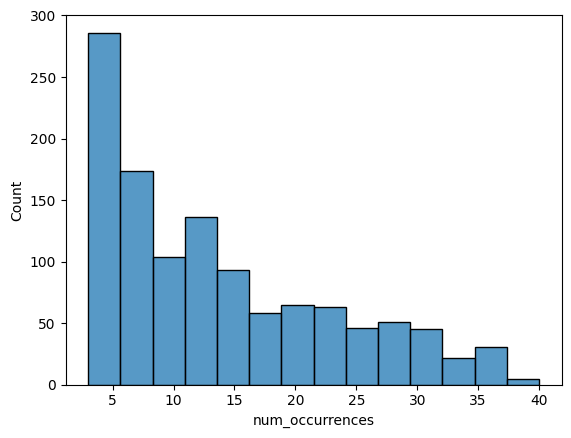

In [107]:
sns.histplot(num_occurrences_labeled.num_occurrences)
plt.show()

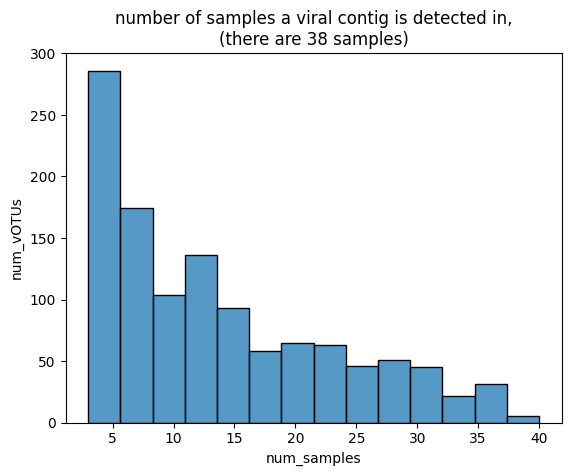

In [108]:
sns.histplot(num_occurrences_labeled['num_occurrences'])
plt.title('number of samples a viral contig is detected in,\n(there are 38 samples)')
plt.xlabel('num_samples')
plt.ylabel('num_vOTUs')
plt.show()


# Plot the most frequent viruses:

In [109]:
most_frequent_contigs = list(
    num_occurrences_labeled
    .sort_values(by='num_occurrences', ascending=False)
    .iloc[:100,:]['Contig'])

In [110]:
most_frequent = melted_df.loc[melted_df['Contig'].isin(most_frequent_contigs)]

# Compare day 14 and 21, similar to Bridget's

In [111]:
most_frequent.loc[(most_frequent['day'] == 14) | (most_frequent['day'] == 21)]

,Sample,day,treatment,Contig,abundance,Host genome,Host taxonomy,Main method,Confidence score,Additional methods,K,P,C,O,F,G,S,prophage
617,STM_0716_E_M_E025,14.0,unamended,20110600_S3M_2_c_000000004785||full_1,0.0,GB_GCA_003137035.1,d__Bacteria;p__Acidobacteriota;c__Acidobacteri...,blast,93.6,None,d__Bacteria,p__Acidobacteriota,c__Acidobacteriae,o__Bryobacterales,f__Bryobacteraceae,g__Fen-330,s__Fen-330 sp003137035,
618,STM_0716_E_M_E025,14.0,unamended,20110600_S3M_2_c_000000004785||full_1,0.0,GB_GCA_003142355.1,d__Bacteria;p__Acidobacteriota;c__Acidobacteri...,blast,92.0,None,d__Bacteria,p__Acidobacteriota,c__Acidobacteriae,o__Bryobacterales,f__Bryobacteraceae,g__Fen-178,s__Fen-178 sp003142355,
619,STM_0716_E_M_E025,14.0,unamended,20110600_S3M_2_c_000000004785||full_1,0.0,GB_GCA_003170915.1,d__Bacteria;p__Acidobacteriota;c__Acidobacteri...,blast,91.6,None,d__Bacteria,p__Acidobacteriota,c__Acidobacteriae,o__Bryobacterales,f__Bryobacteraceae,g__Fen-178,s__Fen-178 sp003170915,
620,STM_0716_E_M_E027,14.0,unamended,20110600_S3M_2_c_000000004785||full_1,6.359976,GB_GCA_003137035.1,d__Bacteria;p__Acidobacteriota;c__Acidobacteri...,blast,93.6,None,d__Bacteria,p__Acidobacteriota,c__Acidobacteriae,o__Bryobacterales,f__Bryobacteraceae,g__Fen-330,s__Fen-330 sp003137035,
621,STM_0716_E_M_E027,14.0,unamended,20110600_S3M_2_c_000000004785||full_1,6.359976,GB_GCA_003142355.1,d__Bacteria;p__Acidobacteriota;c__Acidobacteri...,blast,92.0,None,d__Bacteria,p__Acidobacteriota,c__Acidobacteriae,o__Bryobacterales,f__Bryobacteraceae,g__Fen-178,s__Fen-178 sp003142355,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224823,STM_0716_E_M_E055,21.0,CT,STM_0716_E_M_E069_IS1_megahit_k121_3745||full,182.692792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
224824,STM_0716_E_M_E056,21.0,CT,STM_0716_E_M_E069_IS1_megahit_k121_3745||full,77.778128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
224825,STM_0716_E_M_E058,21.0,catechin,STM_0716_E_M_E069_IS1_megahit_k121_3745||full,84.609117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
224826,STM_0716_E_M_E059,21.0,catechin,STM_0716_E_M_E069_IS1_megahit_k121_3745||full,23.223671,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,


In [112]:
most_frequent.day.unique()

array([ 0., 14., 21., 35.,  7.])

In [113]:
day_14_21 = most_frequent.loc[(most_frequent['day'] == 14) | (most_frequent['day'] == 21)]
day_14_21['day'] = day_14_21['day'].astype(str)

<ipython-input-113-2bab3ad001de>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_14_21['day'] = day_14_21['day'].astype(str)


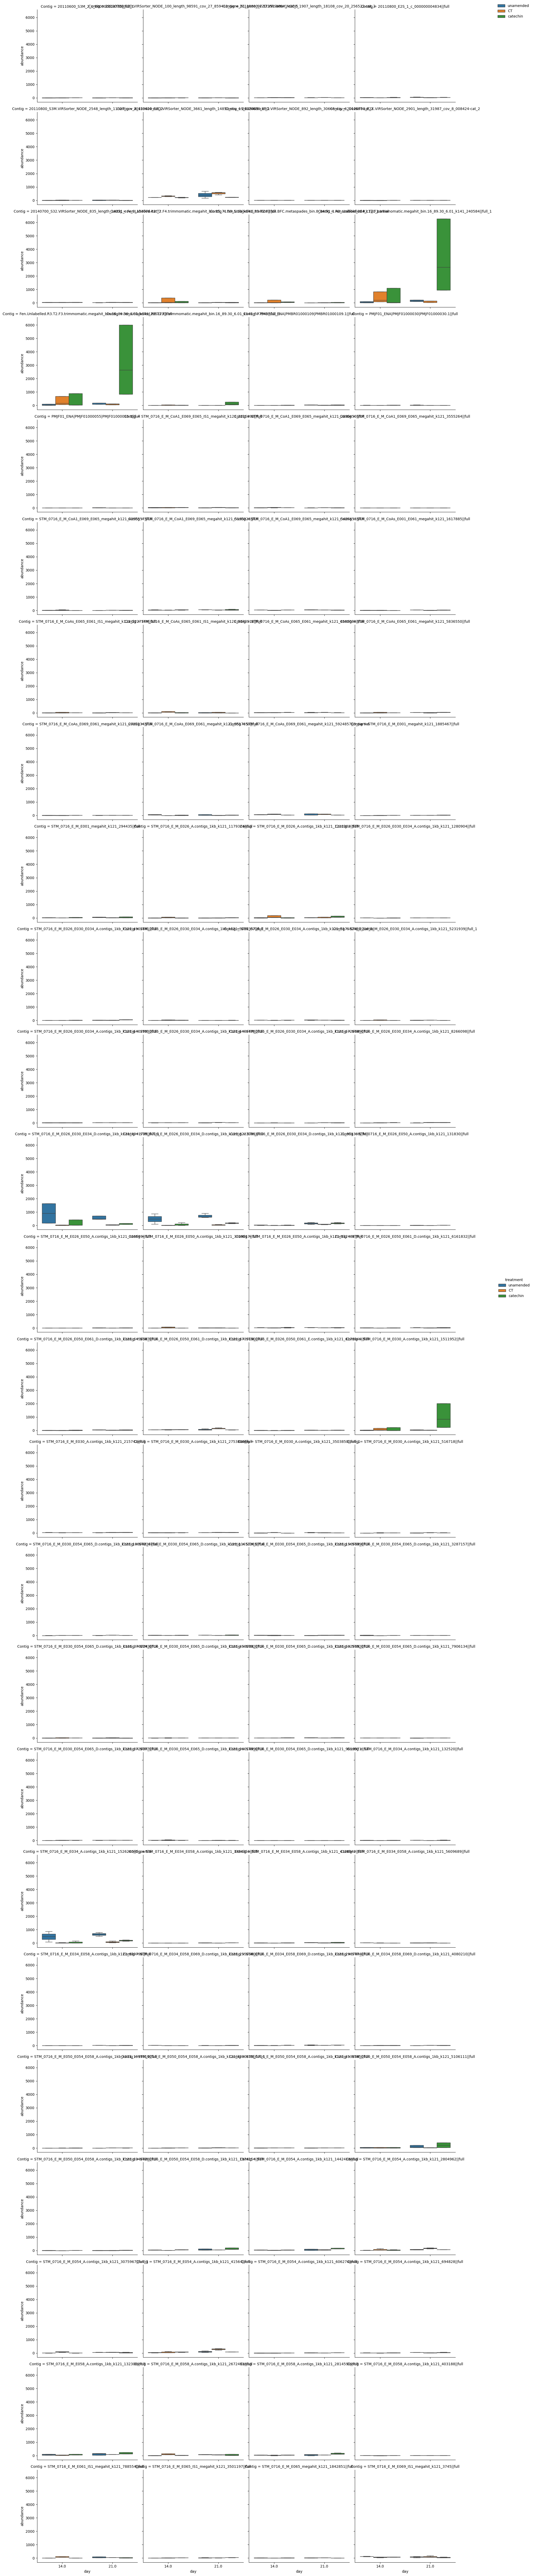

In [114]:
g = sns.catplot(
    data=day_14_21,
    x='day',
    y='abundance',
    hue='treatment',
    col='Contig',
    kind='box',
    col_wrap=4,
    height=4
)
# Adjust legend position
g.add_legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

In [115]:
g = sns.catplot(
    data=day_14_21,
    x='day',
    y='abundance',
    hue='treatment',
    col='Contig',
    kind='box',
    col_wrap=4,
    height=4,
    log=True
)
# Adjust legend position
g.add_legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

TypeError: bxp() got an unexpected keyword argument 'log'

# Filter for only the most wanted

In [108]:
most_wanted = pd.read_csv('../data/grantham_metaT_most_wanted.txt', sep='\t')
most_wanted.head()

,genome,Source,old name,gtdb_r207,ave,treat,log_lda,p-val
0,20110600_E3S_7,EMERGE,NaN,d__Bacteria;p__Desulfobacterota;c__Syntrophia;...,2.252351,unamended,2.754847,0.024975
1,20110700_E1S_1,EMERGE,NaN,d__Bacteria;p__Nitrospirota;c__Thermodesulfovi...,4.083849,unamended,3.380337,0.037373
2,20110700_E2D_7,EMERGE,NaN,d__Bacteria;p__Desulfobacterota;c__Syntrophia;...,2.590305,unamended,2.138383,0.037373
3,20110700_P2D_21,EMERGE,NaN,d__Bacteria;p__Acidobacteriota;c__Acidobacteri...,2.499981,unamended,2.079472,0.037373
4,20110800_E2D_21,EMERGE,NaN,d__Archaea;p__Halobacteriota;c__Bog-38;o__Bog-...,1.477680,unamended,2.508202,0.022230


In [109]:
most_wanted[['K', 'P', 'C', 'O', 'F', 'G', 'S']] = most_wanted['gtdb_r207'].str.split(';', expand=True)

In [110]:
most_wanted_tax_list = most_wanted.G.drop_duplicates().to_list()

In [111]:
most_wanted_tax_list = [i for i in most_wanted_tax_list if i != 'g__']

In [112]:
most_wanted_tax_list

['g__Fen-1087',
 'g__Fen-1308',
 'g__Solibacter',
 'g__Bog-38',
 'g__Bog-257',
 'g__Bog-752',
 'g__Propionicimonas',
 'g__Fen-1273',
 'g__Terracidiphilus',
 'g__CAIVVT01',
 'g__PALSA-270',
 'g__Methanobacterium_B',
 'g__Cryosericum',
 'g__LD21',
 'g__Fen-1038',
 'g__UBA11358',
 'g__Mycobacterium',
 'g__JAFGLP01',
 'g__Paludibacter',
 'g__UBA8389',
 'g__Fen-668',
 'g__UBA9973',
 'g__Cfx3-03',
 'g__Palsa-1439']

In [113]:
most_wanted_viruses = (
    melted_df
    .loc[
        melted_df['G']
        .isin(most_wanted_tax_list)
    ]
)

In [114]:
most_wanted_viruses.to_csv('data/most_wanted_viruses_abundance.tsv', sep='\t')

In [115]:
most_wanted_viruses.Contig.nunique()

361

In [116]:
most_wanted_viruses

,Sample,day,treatment,Contig,abundance,Host genome,Host taxonomy,Main method,Confidence score,Additional methods,K,P,C,O,F,G,S,prophage
418,STM_0716_E_M_E002,0.0,unamended,20100900_E1D.VIRSorter_NODE_1646_length_12567_...,4.270725,GB_GCA_003151855.1,d__Bacteria;p__Verrucomicrobiota;c__Verrucomic...,iPHoP-RF,93.4,None,d__Bacteria,p__Verrucomicrobiota,c__Verrucomicrobiae,o__Pedosphaerales,f__UBA11358,g__UBA11358,s__UBA11358 sp003151855,
421,STM_0716_E_M_E002,0.0,unamended,20100900_E1D.VIRSorter_NODE_1646_length_12567_...,4.270725,3300012943_41,d__Bacteria;p__Verrucomicrobiota;c__Verrucomic...,iPHoP-RF,91.4,None,d__Bacteria,p__Verrucomicrobiota,c__Verrucomicrobiae,o__Pedosphaerales,f__UBA11358,g__UBA11358,s__,
422,STM_0716_E_M_E002,0.0,unamended,20100900_E1D.VIRSorter_NODE_1646_length_12567_...,4.270725,GB_GCA_903918885.1,d__Bacteria;p__Verrucomicrobiota;c__Verrucomic...,iPHoP-RF,90.5,None,d__Bacteria,p__Verrucomicrobiota,c__Verrucomicrobiae,o__Pedosphaerales,f__UBA11358,g__UBA11358,s__UBA11358 sp903918885,
423,STM_0716_E_M_E003,0.0,unamended,20100900_E1D.VIRSorter_NODE_1646_length_12567_...,0.176744,GB_GCA_003151855.1,d__Bacteria;p__Verrucomicrobiota;c__Verrucomic...,iPHoP-RF,93.4,None,d__Bacteria,p__Verrucomicrobiota,c__Verrucomicrobiae,o__Pedosphaerales,f__UBA11358,g__UBA11358,s__UBA11358 sp003151855,
426,STM_0716_E_M_E003,0.0,unamended,20100900_E1D.VIRSorter_NODE_1646_length_12567_...,0.176744,3300012943_41,d__Bacteria;p__Verrucomicrobiota;c__Verrucomic...,iPHoP-RF,91.4,None,d__Bacteria,p__Verrucomicrobiota,c__Verrucomicrobiae,o__Pedosphaerales,f__UBA11358,g__UBA11358,s__,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399902,STM_0716_E_M_E126,7.0,CT,STM_0716_S_M_E085_A_bin.25_k121_187||0_partial,0.0,GB_GCA_903828675.1,d__Bacteria;p__Acidobacteriota;c__Acidobacteri...,blast,93.7,iPHoP-RF;53.00,d__Bacteria,p__Acidobacteriota,c__Acidobacteriae,o__Acidobacteriales,f__Acidobacteriaceae,g__Terracidiphilus,s__Terracidiphilus sp903828675,prophage
399904,STM_0716_E_M_E127,7.0,CT,STM_0716_S_M_E085_A_bin.25_k121_187||0_partial,7.168595,GB_GCA_903828675.1,d__Bacteria;p__Acidobacteriota;c__Acidobacteri...,blast,93.7,iPHoP-RF;53.00,d__Bacteria,p__Acidobacteriota,c__Acidobacteriae,o__Acidobacteriales,f__Acidobacteriaceae,g__Terracidiphilus,s__Terracidiphilus sp903828675,prophage
399906,STM_0716_E_M_E129,7.0,catechin,STM_0716_S_M_E085_A_bin.25_k121_187||0_partial,3.184625,GB_GCA_903828675.1,d__Bacteria;p__Acidobacteriota;c__Acidobacteri...,blast,93.7,iPHoP-RF;53.00,d__Bacteria,p__Acidobacteriota,c__Acidobacteriae,o__Acidobacteriales,f__Acidobacteriaceae,g__Terracidiphilus,s__Terracidiphilus sp903828675,prophage
399908,STM_0716_E_M_E130,7.0,catechin,STM_0716_S_M_E085_A_bin.25_k121_187||0_partial,0.0,GB_GCA_903828675.1,d__Bacteria;p__Acidobacteriota;c__Acidobacteri...,blast,93.7,iPHoP-RF;53.00,d__Bacteria,p__Acidobacteriota,c__Acidobacteriae,o__Acidobacteriales,f__Acidobacteriaceae,g__Terracidiphilus,s__Terracidiphilus sp903828675,prophage


In [117]:
most_wanted_viruses.loc[:,'Contig_HostGenus'] = most_wanted_viruses['Contig'] + '\n' + most_wanted_viruses['G']

/Users/riddellj/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [118]:
most_wanted_viruses

,Sample,day,treatment,Contig,abundance,Host genome,Host taxonomy,Main method,Confidence score,Additional methods,K,P,C,O,F,G,S,prophage,Contig_HostGenus
418,STM_0716_E_M_E002,0.0,unamended,20100900_E1D.VIRSorter_NODE_1646_length_12567_...,4.270725,GB_GCA_003151855.1,d__Bacteria;p__Verrucomicrobiota;c__Verrucomic...,iPHoP-RF,93.4,None,d__Bacteria,p__Verrucomicrobiota,c__Verrucomicrobiae,o__Pedosphaerales,f__UBA11358,g__UBA11358,s__UBA11358 sp003151855,,20100900_E1D.VIRSorter_NODE_1646_length_12567_...
421,STM_0716_E_M_E002,0.0,unamended,20100900_E1D.VIRSorter_NODE_1646_length_12567_...,4.270725,3300012943_41,d__Bacteria;p__Verrucomicrobiota;c__Verrucomic...,iPHoP-RF,91.4,None,d__Bacteria,p__Verrucomicrobiota,c__Verrucomicrobiae,o__Pedosphaerales,f__UBA11358,g__UBA11358,s__,,20100900_E1D.VIRSorter_NODE_1646_length_12567_...
422,STM_0716_E_M_E002,0.0,unamended,20100900_E1D.VIRSorter_NODE_1646_length_12567_...,4.270725,GB_GCA_903918885.1,d__Bacteria;p__Verrucomicrobiota;c__Verrucomic...,iPHoP-RF,90.5,None,d__Bacteria,p__Verrucomicrobiota,c__Verrucomicrobiae,o__Pedosphaerales,f__UBA11358,g__UBA11358,s__UBA11358 sp903918885,,20100900_E1D.VIRSorter_NODE_1646_length_12567_...
423,STM_0716_E_M_E003,0.0,unamended,20100900_E1D.VIRSorter_NODE_1646_length_12567_...,0.176744,GB_GCA_003151855.1,d__Bacteria;p__Verrucomicrobiota;c__Verrucomic...,iPHoP-RF,93.4,None,d__Bacteria,p__Verrucomicrobiota,c__Verrucomicrobiae,o__Pedosphaerales,f__UBA11358,g__UBA11358,s__UBA11358 sp003151855,,20100900_E1D.VIRSorter_NODE_1646_length_12567_...
426,STM_0716_E_M_E003,0.0,unamended,20100900_E1D.VIRSorter_NODE_1646_length_12567_...,0.176744,3300012943_41,d__Bacteria;p__Verrucomicrobiota;c__Verrucomic...,iPHoP-RF,91.4,None,d__Bacteria,p__Verrucomicrobiota,c__Verrucomicrobiae,o__Pedosphaerales,f__UBA11358,g__UBA11358,s__,,20100900_E1D.VIRSorter_NODE_1646_length_12567_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399902,STM_0716_E_M_E126,7.0,CT,STM_0716_S_M_E085_A_bin.25_k121_187||0_partial,0.0,GB_GCA_903828675.1,d__Bacteria;p__Acidobacteriota;c__Acidobacteri...,blast,93.7,iPHoP-RF;53.00,d__Bacteria,p__Acidobacteriota,c__Acidobacteriae,o__Acidobacteriales,f__Acidobacteriaceae,g__Terracidiphilus,s__Terracidiphilus sp903828675,prophage,STM_0716_S_M_E085_A_bin.25_k121_187||0_partial...
399904,STM_0716_E_M_E127,7.0,CT,STM_0716_S_M_E085_A_bin.25_k121_187||0_partial,7.168595,GB_GCA_903828675.1,d__Bacteria;p__Acidobacteriota;c__Acidobacteri...,blast,93.7,iPHoP-RF;53.00,d__Bacteria,p__Acidobacteriota,c__Acidobacteriae,o__Acidobacteriales,f__Acidobacteriaceae,g__Terracidiphilus,s__Terracidiphilus sp903828675,prophage,STM_0716_S_M_E085_A_bin.25_k121_187||0_partial...
399906,STM_0716_E_M_E129,7.0,catechin,STM_0716_S_M_E085_A_bin.25_k121_187||0_partial,3.184625,GB_GCA_903828675.1,d__Bacteria;p__Acidobacteriota;c__Acidobacteri...,blast,93.7,iPHoP-RF;53.00,d__Bacteria,p__Acidobacteriota,c__Acidobacteriae,o__Acidobacteriales,f__Acidobacteriaceae,g__Terracidiphilus,s__Terracidiphilus sp903828675,prophage,STM_0716_S_M_E085_A_bin.25_k121_187||0_partial...
399908,STM_0716_E_M_E130,7.0,catechin,STM_0716_S_M_E085_A_bin.25_k121_187||0_partial,0.0,GB_GCA_903828675.1,d__Bacteria;p__Acidobacteriota;c__Acidobacteri...,blast,93.7,iPHoP-RF;53.00,d__Bacteria,p__Acidobacteriota,c__Acidobacteriae,o__Acidobacteriales,f__Acidobacteriaceae,g__Terracidiphilus,s__Terracidiphilus sp903828675,prophage,STM_0716_S_M_E085_A_bin.25_k121_187||0_partial...


# Figure out what method was used to predict different hosts

In [119]:
most_wanted_viruses.Contig.nunique()

361

In [121]:
most_wanted_viruses.drop_duplicates(subset="Contig")[['Contig','Main method', 'prophage']].to_csv('data/host_prediction_method_most_wanted.tsv', sep='\t', index=False)

# Explore raw readcounts to get a sense:

In [86]:
readcounts = pd.read_csv('data/ALL-SAMPLES-coverm_readcounts.txt', sep=',')
readcounts.head()

,Contig,STM_0716_E_M_E031 Read Count,STM_0716_E_M_E060 Read Count,STM_0716_E_M_E070 Read Count,STM_0716_E_M_E030 Read Count,STM_0716_E_M_E063 Read Count,STM_0716_E_M_E025 Read Count,STM_0716_E_M_E122 Read Count,STM_0716_E_M_E035 Read Count,STM_0716_E_M_E130 Read Count,...,STM_0716_E_M_E055 Read Count,STM_0716_E_M_E072 Read Count,STM_0716_E_M_E052 Read Count,STM_0716_E_M_E027 Read Count,STM_0716_E_M_E034 Read Count,STM_0716_E_M_E003 Read Count,STM_0716_E_M_E050 Read Count,STM_0716_E_M_E125 Read Count,STM_0716_E_M_E056 Read Count,STM_0716_E_M_E127 Read Count
0,20160700_E14.VIRSorter_NODE_1_length_351989_co...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,STM_0716_E_M_E034_E058_A.contigs_1kb_k121_5845...,0,2043,0,0,0,0,0,463,76,...,0,2076,0,0,28998,0,62,0,0,0
2,20120700_P3D.VIRSorter_NODE_161_length_217151_...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,20130700_S2X.VIRSorter_NODE_3_length_197518_co...,1421,645,283,1856,3941,418,1224,362,1560,...,1346,1973,869,1239,671,1856,516,2842,1504,3324
4,20140700_S11.VIRSorter_NODE_5_length_190782_co...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [87]:
readcounts.iloc[:,8]

0          0
1        463
2          0
3        362
4          0
        ... 
17338      0
17339      0
17340      0
17341     12
17342      2
Name: STM_0716_E_M_E035 Read Count, Length: 17343, dtype: int64

In [88]:
readcounts.loc[readcounts['STM_0716_E_M_E035 Read Count'] == readcounts.iloc[:,8].max()]

,Contig,STM_0716_E_M_E031 Read Count,STM_0716_E_M_E060 Read Count,STM_0716_E_M_E070 Read Count,STM_0716_E_M_E030 Read Count,STM_0716_E_M_E063 Read Count,STM_0716_E_M_E025 Read Count,STM_0716_E_M_E122 Read Count,STM_0716_E_M_E035 Read Count,STM_0716_E_M_E130 Read Count,...,STM_0716_E_M_E055 Read Count,STM_0716_E_M_E072 Read Count,STM_0716_E_M_E052 Read Count,STM_0716_E_M_E027 Read Count,STM_0716_E_M_E034 Read Count,STM_0716_E_M_E003 Read Count,STM_0716_E_M_E050 Read Count,STM_0716_E_M_E125 Read Count,STM_0716_E_M_E056 Read Count,STM_0716_E_M_E127 Read Count
816,STM_0716_E_M_CoAs_E069_E061_IS1_megahit_k121_2...,0,629901,1380496,74,18,0,0,3756469,8297,...,239,717356,0,0,2601388,74,1233,0,112,0


In [89]:
readcounts.describe().iloc[-1,:]

STM_0716_E_M_E031 Read Count      84277.0
STM_0716_E_M_E060 Read Count     629901.0
STM_0716_E_M_E070 Read Count    1380496.0
STM_0716_E_M_E030 Read Count      43286.0
STM_0716_E_M_E063 Read Count      94174.0
STM_0716_E_M_E025 Read Count     331678.0
STM_0716_E_M_E122 Read Count      49332.0
STM_0716_E_M_E035 Read Count    3756469.0
STM_0716_E_M_E130 Read Count     154989.0
STM_0716_E_M_E121 Read Count     269733.0
STM_0716_E_M_E066 Read Count      32427.0
STM_0716_E_M_E004 Read Count      10002.0
STM_0716_E_M_E051 Read Count      64978.0
STM_0716_E_M_E062 Read Count     284701.0
STM_0716_E_M_E131 Read Count     222452.0
STM_0716_E_M_E126 Read Count       8614.0
STM_0716_E_M_E064 Read Count     209172.0
STM_0716_E_M_E058 Read Count     902525.0
STM_0716_E_M_E054 Read Count      10454.0
STM_0716_E_M_E033 Read Count     407750.0
STM_0716_E_M_E068 Read Count      39200.0
STM_0716_E_M_E067 Read Count      82584.0
STM_0716_E_M_E123 Read Count     538346.0
STM_0716_E_M_E129 Read Count     4